## Model Misspecification in SBI

<Introduction: ...>




References:
- [1] [Schmitt et al, 2024](https://arxiv.org/abs/2112.08866)
- [2] [Kelly et al, 2025](https://arxiv.org/abs/2503.12315)
- [3] [Gretton et al, 2012](https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

from sbi.diagnostics.misspecification import (
    calc_misspecification_mmd,  # Import the MMD diagnostic
)
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

# Set seed
seed = 2025
torch.manual_seed(seed)

/Users/swagatam/miniconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Prior Misspecification Example on the Gaussian Simulator

In this example, we work with the following simulator: the prior $\theta \sim \mathcal{N}(0, I_d)$, and the observations $x|\theta \sim \mathcal{N}(\theta, I_d)$ where $d$ is the dimensionality of the problem. For the purposes of this example, we would assume the observations, i.e., $x_o$ would come from the (true) data generating process above.

Now we demonstrate a concrete example of model misspecification scenario in SBI. We assume our posterior inference network (e.g., NPE) would be fitted on $(\theta, x)$ pairs where the $\theta$ values are sampled from $\mathcal{N}(\mu, I_d)$ (instead of $\mathcal{N}(0, I_d)$, i.e., with some offset mean $\mu$), and the corresponding observations $x$ were generated using the simulator as above. We refer to this manifestation of model misspecification as **prior misspecification**, and demonstrate how we can identify this using (one or many) observations $x_o$ during test time, following the maximum mean discrepancy (MMD) based approach outlined in [1]. 

The core idea of the method is to compute a distribution of MMD values among the synthetic simulations ($x$) the model was trained on, and perform an out-of-distribution/p-value check for the MMD between the synthetic simulations and the $x_o$. Since we will often encounter only one observation $x_o$ during inference, we would make use of the biased version of sample-based MMD recommended in [3]. 

### Define the ground-truth and misspecified priors
The "ground-truth" prior simply means the $x_{obs}$ will come from this prior distribution through the simulator.
The misspecified prior: the NPE will be trained on $(\theta, x)$ pairs coming from this prior. Note that the simulator code is same in both cases.

In [2]:
dim = 2  # observation dimension
# true prior -- the observation comes from here
mean_true = torch.zeros(dim)
cov_true = torch.eye(dim)
prior_true = dist.MultivariateNormal(loc=mean_true, covariance_matrix=cov_true)


# the NPE will be trained on samples from this misspecified prior
def give_misspec_prior(mu0, tau0):
    if mu0.ndim > 1:
        raise ValueError("mu0 should be a 1d tensor of shape [dim]")
    dim = mu0.shape[0]
    return dist.MultivariateNormal(loc=mu0, covariance_matrix=tau0 * torch.eye(dim))


offset = 4
mu0 = mean_true + offset  # just offset, applies in all directions
tau0 = 1.0  # 1.0 means no change in covariance matrix
prior_mis = give_misspec_prior(mu0, tau0)


def simulator(theta):
    return theta + torch.randn_like(theta)

### Create the training dataset for the NPE, i.e., $(\theta, x)$ pairs
As we will see later, we can only train one NPE on the well-specified dataset, and simulate the other scenarios exploiting the symmetry present in our setting.
We will also generate a validation dataset, to compute many _self_ MMDs or the distribution of MMDs which will be utilised later for the actual misspecification check.

In [3]:
num_simulations = 1000

# generate training data for clean/well-specified model
theta_well = prior_true.sample((num_simulations,))
x_well = simulator(theta_well)


# validation set to compute MMD distribution in the well-specified case
# this could just be a subset of the training data

num_validations_mmd = 1000
theta_val_well = prior_true.sample((num_validations_mmd,))
x_val_well = simulator(theta_val_well)

print(theta_well.shape, theta_val_well.shape)

torch.Size([1000, 2]) torch.Size([1000, 2])


### Train our inference object
We are only training one NPE inference with an embedding network to demonstrate the MMD-based misspecification check both on the original _x-space_ and the _embedding_ space.

In [4]:
def train_npe_with_embedding(theta, x, prior, embeddding_net, **kwargs):
    neural_posterior = posterior_nn(model="maf", embedding_net=embeddding_net)
    inference = NPE(prior=prior, density_estimator=neural_posterior, **kwargs)
    inference = inference.append_simulations(theta, x)
    _ = inference.train()
    return inference


emb_net_well = FCEmbedding(
    input_dim=dim, output_dim=dim, num_layers=2, num_hiddens=20
)  # minimal embedding network
NPE_well_embd = train_npe_with_embedding(
    theta_well, x_well, prior=prior_true, embeddding_net=emb_net_well
)  # modified the emb_net

 Neural network successfully converged after 199 epochs.

### Create the observations $x_{obs}$ to do inference
We will generate two observations: one from the ground-truth prior to demonstrate the case where we **do not** have any model misspecification. The second observation will be generated from the misspecified prior to _simulate_ the model misspecification scenario when our inference was trained on the misspecified data, but the observation comes from the ground-truth prior. 

In [5]:
# do inference given observed data
num_observations = 1
theta_o = prior_true.sample((num_observations,))
x_o = simulator(theta_o)

# print(f"theta_o (comes from true prior): {theta_o}")
# print(f"x_o (comes from simulator using theta_o): {x_o}")

# we can also create observation from the misspecified prior x_o_mis
theta_o_mis = prior_mis.sample((num_observations,))
x_o_mis = simulator(theta_o_mis)

# print(f"theta_o_mis (comes from misspecified prior): {theta_o_mis}")
# print(f"x_o_mis (comes from simulator using theta_o_mis): {x_o_mis}")

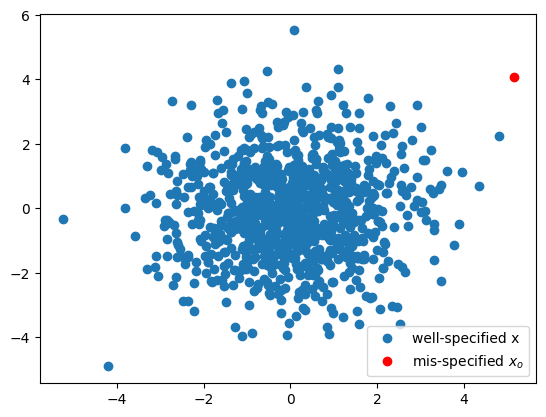

In [6]:
plt.plot(x_val_well[:, 0], x_val_well[:, 1], "o", label="well-specified x")
plt.plot(x_o_mis[:, 0], x_o_mis[:, 1], "o", color="red", label=r"mis-specified $x_o$")
plt.legend(loc='lower right')
plt.show()

### Misspecification detection
Here we only demonstrate misspecification detection on the embedding space. Note that the corresponding scenarios on the x-space could be simply tested by passing `inference=None` and `mode=x_space` in the functions below.

p-val: 0.501000


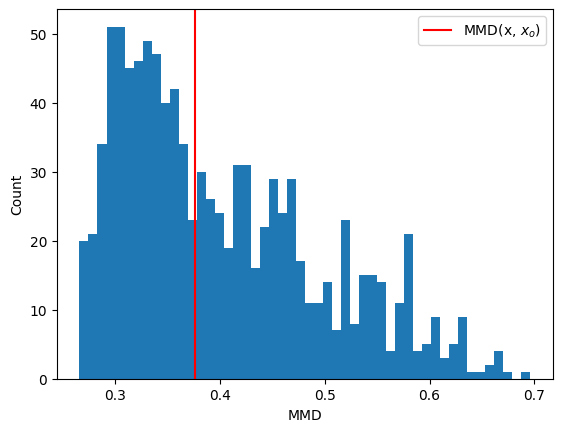

In [7]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=NPE_well_embd, x_obs=x_o, x=x_val_well, mode='embedding'
)

print(f"p-val: {p_val:.6f}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red", label=r'MMD(x, $x_o$)')

plt.ylabel('Count')
plt.xlabel('MMD')

plt.legend()

plt.show()

**Interpretation:** In the above example, the observed data $x_o$ comes from the same ground truth prior as what the NPE estimator was trained on. As detected by the check above, the $p$-value for the null hypothesis $H_0$ (that the distribution of MMDs between samples in `x_val_well` (intra) and the distribution of MMDs between `x_val_well` and `x_o` are same) came out to be $0.501 \gt 0.05$, so we fail to reject the null hypothesis, i.e., no misspecification is detected in this case.

Now we turn to the situation where there is a misspecification.

p-val: 0.0


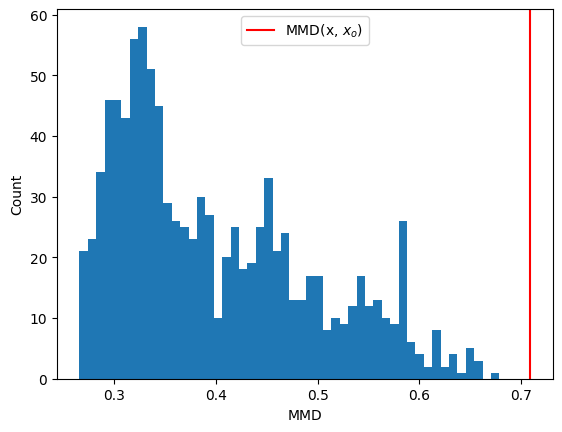

In [8]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=NPE_well_embd, x_obs=x_o_mis, x=x_val_well, mode='embedding'
)

print(f"p-val: {p_val}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red", label=r'MMD(x, $x_o$)')
plt.ylabel('Count')
plt.xlabel('MMD')
plt.legend()
plt.show()

As expected, in this case the $p$-value is $0.0$ so we reject the null hypothesis, and can warn the user that there might be mismatch in distribution between the observed sample $x_o$, and the dataset on which the inference network was trained on.